In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev, random
from jax import random, device_put
#rom jax.scipy.special import kl_div

# from jax import config
# config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import time
rng = np.random.default_rng()
key = random.PRNGKey(0)

from pathgradient import *
import sampling

In [ ]:
# Get the gradients of the CDF with respect to the parameters

# Final energy (x)
grad_x_cdf = jit(jacfwd(jax_cdf_differential_decay_width, argnums=0))
# Initial energy (Ei)
grad_Ei_cdf = jit(jacfwd(jax_cdf_differential_decay_width, argnums=1))
# Parameters (theta)
grad_theta_cdf = jit(jacfwd(jax_cdf_differential_decay_width, argnums=3))

# -----------------------------------------------
# Get the gradients of the final energy

# Gradient of the final energy with respect to the parameters
def grad_theta_x(final_energy, initial_energy, meta_params, params):
    grad_theta_x_val = {}
    grad_x_cdf_val = grad_x_cdf(final_energy, initial_energy, meta_params, params)
    grad_theta_cdf_val = grad_theta_cdf(final_energy, initial_energy, meta_params, params)

    for param in params:
        grad_theta_x_val[param] = - grad_theta_cdf_val[param] / grad_x_cdf_val

    return grad_theta_x_val

# Gradient of the final energy with respect to the initial energy
def grad_Ei_x(final_energy, initial_energy, meta_params, params):
    grad_Ei_x_val = {}
    grad_x_cdf_val = grad_x_cdf(final_energy, initial_energy, meta_params, params)
    grad_Ei_cdf_val = grad_Ei_cdf(final_energy, initial_energy, meta_params, params)

    for param in params:
        grad_Ei_x_val[param] = - grad_Ei_cdf_val[param] / grad_x_cdf_val

    return grad_Ei_x_val


In [ ]:
# Timing and shapes

initial_energy = 23.0
final_energy = 15.0

discrete_energies = DISCRETE_ENERGIES
discrete_continuum_boundary = DISCRETE_CONTINUUM_BOUNDARY
meta_params = META_PARAMS

disp_parameter = 0.01
alpha = 1.0
beta = 10.0
params = {'disp_parameter': disp_parameter,
            'alpha': alpha,
            'beta': beta}

# %timeit grad_x_cdf_val = grad_x_cdf(final_energy, initial_energy, meta_params, params)
# %timeit grad_Ei_cdf_val = grad_Ei_cdf(final_energy, initial_energy, meta_params, params)
# %timeit grad_theta_cdf_val = grad_theta_cdf(final_energy, initial_energy, meta_params, params)
%timeit grad_theta_x_val = grad_theta_x(final_energy, initial_energy, meta_params, params)
%timeit grad_theta_x_jit_val = grad_theta_x_jit(final_energy, initial_energy, meta_params, params)

# grad_x_cdf_val = grad_x_cdf(final_energy, initial_energy, meta_params, params)
# print(grad_x_cdf_val.shape, type(grad_x_cdf_val))
# grad_Ei_cdf_val = grad_Ei_cdf(final_energy, initial_energy, meta_params, params)
# print(grad_Ei_cdf_val.shape, type(grad_Ei_cdf_val))
# grad_theta_cdf_val = grad_theta_cdf(final_energy, initial_energy, meta_params, params)
# print(type(grad_theta_cdf_val))
# print(grad_theta_cdf_val["disp_parameter"])

In [ ]:
# Finite differences test

initial_energy = 23.0
final_energy = 15.0

meta_params = META_PARAMS

disp_parameter = 0.01
alpha = 1.0
beta = 10.0
params = {'disp_parameter': disp_parameter,
            'alpha': alpha,
            'beta': beta}

epsilon = 1e-5
# Sample an event
r = 0.4
next_energy, continuum_cut = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, meta_params, params)

# Sample other close events
params_plus = {'disp_parameter': disp_parameter + epsilon, 'alpha': alpha, 'beta': beta}
next_energy_plus, continuum_cut_plus = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, meta_params, params_plus)

params_minus = {'disp_parameter': disp_parameter - epsilon, 'alpha': alpha, 'beta': beta}
next_energy_minus, continuum_cut_minus = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, meta_params, params_minus)


# Calculate the gradient with finite differences and with the analytical jax gradient
print(next_energy, "NE", continuum_cut, "CC")
grad_theta_x_fd = (next_energy_plus - next_energy_minus) / (2 * epsilon)
grad_theta_x_jx = grad_theta_x(next_energy, initial_energy, meta_params, params)

print(grad_theta_x_fd, grad_theta_x_jx, "chirp")


In [ ]:
%matplotlib widget

sample_num = 5000
num_passes = 5
initial_energy = 23.0 * np.ones(sample_num)
meta_params = META_PARAMS
params = {'disp_parameter': 0.01,
            'alpha': 1.0,
            'beta': 10.0}

key = random.PRNGKey(0)

energies, continuum_cuts = sampling.sample_continuum_path(initial_energy, meta_params, params, 
                                        key, sample_num=sample_num, passes=num_passes,
                                        max_continuum_steps=2, use_continuum_cut=True)


print(np.where(energies[0] == 23.0))

# Plot
plt.figure()
plt.scatter(energies[0], energies[1], s=4)
# Plot the x=y line
discrete_continuum_boundary = meta_params['discrete_continuum_boundary']
plt.plot([-1, 23], [-1, 23], color='black', linestyle='--')
# Set the axis limits
# plt.xlim([discrete_continuum_boundary, 23])
# plt.ylim([discrete_continuum_boundary, 23])
# Set aspect ratio to 1
plt.gca().set_aspect('equal', adjustable='box')

plt.figure()
# 2D hist with a log cmap
bins_x = np.linspace(discrete_continuum_boundary, 23, 100)
bins_y = np.linspace(discrete_continuum_boundary, 23, 100)
plt.hist2d(energies[0], energies[1], bins=[bins_x, bins_y], cmap='gnuplot', norm = mpl.colors.LogNorm())
# Set aspect ratio to 1
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

plt.figure()


## Test the discrete probability computation and sampling

In [2]:
#initial_energy = 23.0 * np.ones(sample_num)
meta_params = META_PARAMS
params = {'disp_parameter': 0.01,
            'alpha': 1.0,
            'beta': 10.0}


continuum_energy = 17.02

discrete_path_probs_body, discrete_paths = sampling.get_discrete_tree_body(meta_params, params)

discrete_path_probs, discrete_paths = sampling.get_full_discrete_tree(continuum_energy, (discrete_path_probs_body, discrete_paths), meta_params, params)

print(discrete_paths.shape, discrete_path_probs.shape)

# Should add up to 1
print(np.sum(discrete_path_probs))

# Should add up to 1
starting_discrete_level = 6
total_prob = 0.0
for i, path in enumerate(discrete_paths):
    if path[0] == starting_discrete_level:
        total_prob += discrete_path_probs_body[i]
print(total_prob)   

(128, 8) (128,)
1.0
1.0000000237487257


In [3]:
# Sampling 
meta_params = META_PARAMS
params = {'disp_parameter': 0.01,
            'alpha': 1.0,
            'beta': 10.0}

continuum_energy = 13.4

key, subkey = random.split(key)
start = time.time()
for i in range(1000):
    key, subkey = random.split(key)
    discrete_path = sampling.sample_discrete_path_obo(continuum_energy, meta_params, params, subkey)

end = time.time()
print(end - start)

print(np.array(discrete_path))


3.4356369972229004
[5 1 0]


In [4]:
# Sampling using discrete tree
meta_params = META_PARAMS
params = {'disp_parameter': 0.01,
            'alpha': 1.0,
            'beta': 10.0}

# Tree body
discrete_path_probs_body, discrete_paths = sampling.get_discrete_tree_body(meta_params, params)

key, subkey = random.split(key)
continuum_energies = random.uniform(subkey, shape=(1000,), minval=meta_params['discrete_continuum_boundary'], maxval=23.0)
discrete_path_probs, discrete_paths = sampling.get_full_discrete_tree_vmap(continuum_energies, (discrete_path_probs_body, discrete_paths), meta_params, params)

print(discrete_paths.shape, discrete_path_probs.shape)

# Now we sample
key, subkey = random.split(key)
# random_numbers = random.uniform(subkey, shape=(10000,))

# discrete_path_probs_cumsum = jnp.cumsum(discrete_path_probs, axis=1)
# path_indices = np.array([np.searchsorted(row, rnd_num) for row, rnd_num in zip(discrete_path_probs_cumsum, random_numbers)])
# print(discrete_paths[path_indices])

path_indices, paths, path_energies = sampling.sample_discrete_path(continuum_energies, 
                                                        (discrete_path_probs, discrete_paths), meta_params, params, subkey)

print(path_indices.shape, paths.shape, path_energies.shape)


(128, 8) (1000, 128)
(1000,) (1000, 8) (1000, 8)


In [2]:
# Now let's sample a full set of paths
sample_num = 5000
num_passes = 1
max_continuum_steps = 4
initial_energy = 23.0 * np.ones(sample_num)

meta_params = META_PARAMS
params = {'disp_parameter': 0.010,
            'alpha': 1.0,
            'beta': 10.0}

# First, sample the continuum paths
key, subkey = random.split(key)
continuum_energies, last_continuum_energies, last_continuum_energies_idx, continuum_cuts,\
        energy_theta_gradients,energy_total_theta_gradients, energy_Ei_gradients, continuum_cut_gradients =\
             sampling.sample_continuum_path(initial_energy, meta_params, params, 
                                        subkey, sample_num=sample_num, passes=num_passes,
                                        max_continuum_steps=max_continuum_steps, use_continuum_cut=True)

print("Continuum energies shape:", continuum_energies.shape, continuum_cuts.shape)
# Now, see when the continuum paths go to discrete
# This is the last entry of the continuum path before it hits -1

# Get the indices of the last entry before the continuum path hits -1
first_minus_one_index = np.argmax((continuum_energies == -1.), axis=1)
keep_paths = np.where(first_minus_one_index != 0)[0]

print(continuum_energies[0, :])
print(first_minus_one_index[0], first_minus_one_index.shape)

# Get rid of continuum paths that never hit -1, and the last continuum energies
#last_continuum_energies = np.array([continuum_energies[i, first_minus_one_index[i]-1] for i in keep_paths])
filtered_continuum_energies = continuum_energies[keep_paths, :]
last_continuum_energies = last_continuum_energies[keep_paths]

print(filtered_continuum_energies.shape, last_continuum_energies.shape)

# Now, sample the discrete paths
# Get the discrete tree
key, subkey = random.split(key)
discrete_path_probs_body, discrete_paths = sampling.get_discrete_tree_body(meta_params, params)
discrete_path_probs, discrete_paths = sampling.get_full_discrete_tree_vmap(last_continuum_energies, (discrete_path_probs_body, discrete_paths), meta_params, params)

discrete_path_indices, discrete_paths, discrete_path_energies = sampling.sample_discrete_path(last_continuum_energies, 
                                                        (discrete_path_probs, discrete_paths), meta_params, params, subkey)

print(discrete_path_indices.shape, discrete_paths.shape, discrete_path_energies.shape)

# Finally, combine the continuum and discrete paths and get rid of any trailing -1s and 0s
# Combine the energy paths
full_energy_paths = sampling.stitch_paths(filtered_continuum_energies, discrete_path_energies)

# idx = 0
# print(filtered_continuum_energies[idx], discrete_path_energies[idx])
# print(combined_energies[idx])

Pass 1 of 1


/Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/diff-deexcitation/pathgradient.py:165: RuntimeWarning: invalid value encountered in divide
  stay_in_continuum_probability = cdf_norm / (cdf_norm + total_decay_width_to_discrete)


Continuum energies shape: (5000, 6) (5000, 6)
[23. -1. -1. -1. -1. -1.]
1 (5000,)
(4994, 6) (4994,)
(4994,) (4994, 8) (4994, 8)


[23. -1. -1. -1. -1. -1.] [5. 3. 0. 0. 0. 0. 0. 0.]
[23.  5.  3.  0.]
------


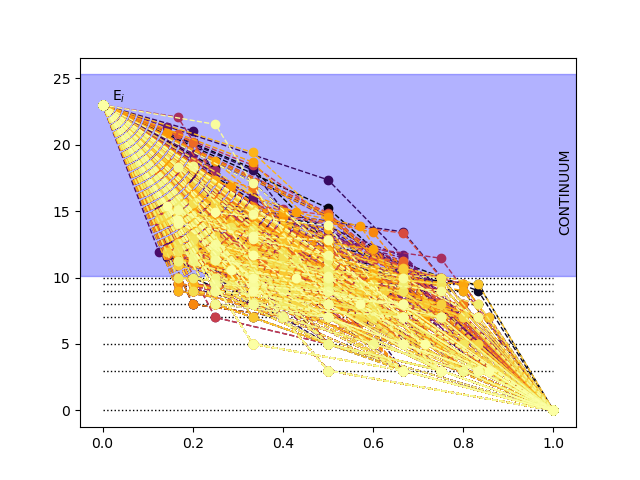

In [3]:
initial_energy = 23.0
discrete_continuum_boundary = meta_params['discrete_continuum_boundary']
discrete_energies = meta_params['discrete_energies']

num_paths = 1000
full_level_paths = full_energy_paths[0:num_paths]
#print(combined_energies[1])

idx = 8
print(filtered_continuum_energies[idx], discrete_path_energies[idx])
print(full_energy_paths[idx])
print('------')

%matplotlib widget
plt.figure()
# Plot the continuum energy range (from discrete/continuum boundary to start energy) as a rectangle
plt.axhspan(discrete_continuum_boundary * 1.01, initial_energy * 1.1, alpha=0.3, color='blue')
# Add a "CONTINUUM" label to the right, rotated 90 degrees
plt.text(1.01, (discrete_continuum_boundary + initial_energy)/2, 'CONTINUUM', rotation=90, verticalalignment='center', horizontalalignment='left')
# Plot the discrete energy levels as horizontal lines
plt.hlines(discrete_energies, 0, 1, color='black', linewidth=1, linestyles='dotted')

# Add a label for the initial energy
plt.text(0.05, initial_energy, r'E$_i$', verticalalignment='bottom', horizontalalignment='right')
cmap = plt.cm.inferno
colors = cmap(np.linspace(0, 1, num_paths))

for i, full_level_path in enumerate(full_level_paths):
    #print(full_level_path)

    # Plot the full energy path as a scatter joined with dashed lines
    plt.plot(np.linspace(0, 1, len(full_level_path)), full_level_path, color=colors[i], linestyle='--', marker='o', linewidth=1)


## Minimization

In [4]:
def gaussian_kernel(x, y, sigma=1.0):
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

def mmd_loss(x, y, kernel):
    # y is SIMULATED, x is TRUTH (doesn't matter, it's symmetric)
    x_kernel = jnp.mean(vmap(lambda xi: jnp.mean(vmap(lambda xj: kernel(xi, xj))(x)))(x))
    y_kernel = jnp.mean(vmap(lambda yi: jnp.mean(vmap(lambda yj: kernel(yi, yj))(y)))(y))
    xy_kernel = jnp.mean(vmap(lambda xi: jnp.mean(vmap(lambda yj: kernel(xi, yj))(y)))(x))
    return jnp.mean(x_kernel + y_kernel - 2 * xy_kernel)

def gaussian_kernel_obo(x, y, sigma=1.0):

    bandwidth_range = np.array([0.1, 1.0, 2.0, 10., 15., 20., 50., 150.])
    kernel = 0.0

    for bw in bandwidth_range:
        kernel += jnp.exp(-(x - y)**2 / (2 * bw))

    return kernel

gaussian_kernel_vmap_1 = vmap(gaussian_kernel_obo, in_axes=(0, None), out_axes=0)
gaussian_kernel_vmap = vmap(gaussian_kernel_vmap_1, in_axes=(None, 0), out_axes=1)


def mmd_loss_weighted(x, y, weights, kernel_vmap):
    # y is SIMULATED, x is TRUTH (doesn't matter, it's symmetric)
    m = x.shape[0]
    n = y.shape[0]
    n_weighted = jnp.sum(weights)

    kernel_x_matrix = kernel_vmap(x, x)
    kernel_y_matrix = kernel_vmap(y, y)
    # Make the diagonal entries 0
    kernel_x_matrix = jnp.where(jnp.eye(m), 0, kernel_x_matrix)
    kernel_y_matrix = jnp.where(jnp.eye(n), 0, kernel_y_matrix)
    # print(kernel_x_matrix[5,5], "kxm")

    x_kernel = 1 / (m * (m - 1)) * jnp.sum(kernel_x_matrix)
    y_kernel = 1 / (n_weighted * (n_weighted - 1)) * jnp.sum(kernel_y_matrix * jnp.outer(weights, weights))
    xy_kernel = 1 / (m * n_weighted) * jnp.sum(kernel_vmap(x, y) * jnp.repeat(weights[jnp.newaxis, :], m, axis=0))

    # print(jnp.repeat(weights[jnp.newaxis, :], m, axis=0).shape)
    # print(x_kernel, y_kernel, 2*xy_kernel)

    return x_kernel + y_kernel - 2 * xy_kernel

mmd_loss_weighted = jit(mmd_loss_weighted, static_argnums=(3,))

key, *subkeys = random.split(key, 4)
x = random.normal(subkeys[0], shape=(100,))
y = random.normal(subkeys[1], shape=(900,)) * 1.2

weights = jnp.ones(y.shape[0]) * 0.6
#weights = random.uniform(subkeys[2], shape=(y.shape[0],))
print(mmd_loss(x, y, gaussian_kernel))

mmdw = mmd_loss_weighted(x, y, weights, gaussian_kernel_vmap)
print(mmdw)
# print(mmd_loss_weighted(y, x, weights, gaussian_kernel_vmap))

# Gradients
grad_mmd_loss = grad(mmd_loss, argnums=1)
print(grad_mmd_loss(x, y, gaussian_kernel)[0])

grad_mmd_loss_weighted = jit(grad(mmd_loss_weighted, argnums=1), static_argnums=(3,))
print(grad_mmd_loss_weighted(x, y, weights, gaussian_kernel_vmap)[0])

0.023784876
0.060310364
0.00010871957
0.00045018998


In [10]:
# Gradients of the discrete tree (i.e., gradients of the probabilities of each path)
meta_params = META_PARAMS
params = {'disp_parameter': 0.01,
            'alpha': 1.0,
            'beta': 10.0}
continuum_energy = 12.0

# Tree head
grad_theta_discrete_tree_head = jit(jacfwd(sampling.get_discrete_tree_head, argnums=2))
grad_energy_discrete_tree_head = jacfwd(sampling.get_discrete_tree_head, argnums=0)

discrete_tree_head_val = sampling.get_discrete_tree_head(continuum_energy, meta_params, params)
grad_theta_discrete_tree_head_val = grad_theta_discrete_tree_head(continuum_energy, meta_params, params)
print(grad_theta_discrete_tree_head_val)

# Tree body (does not depend on the parameters for now)
discrete_tree_body_val, discrete_paths = sampling.get_discrete_tree_body(meta_params, params)

# Full tree
grad_theta_full_discrete_tree = jacfwd(sampling.get_full_discrete_tree, argnums=3, has_aux=True)
grad_energy_full_discrete_tree = jacfwd(sampling.get_full_discrete_tree, argnums=0, has_aux=True)

discrete_tree_val, discrete_tree_probs_val = sampling.get_full_discrete_tree(continuum_energy, (discrete_tree_body_val, discrete_paths), meta_params, params)
grad_theta_full_discrete_tree_val, _ = grad_theta_full_discrete_tree(continuum_energy, (discrete_tree_body_val, discrete_paths), meta_params, params)

print(grad_theta_full_discrete_tree_val['alpha'].shape)

# Vmap
grad_theta_full_discrete_tree_vmap = jit(jacfwd(sampling.get_full_discrete_tree_vmap, argnums=3, has_aux=True))
grad_energy_full_discrete_tree_vmap = vmap(grad_energy_full_discrete_tree, in_axes=(0, None, None, None), out_axes=(0,None))

continuum_energies = jnp.linspace(12.0, 23.0, 100)
discrete_tree_val, discrete_tree_probs_val = sampling.get_full_discrete_tree_vmap(continuum_energies, (discrete_tree_body_val, discrete_paths), meta_params, params)
grad_theta_full_discrete_tree_vmap_val, _ = grad_theta_full_discrete_tree_vmap(continuum_energies, (discrete_tree_body_val, discrete_paths), meta_params, params)
grad_energy_full_discrete_tree_vmap_val, _ = grad_energy_full_discrete_tree_vmap(continuum_energies, (discrete_tree_body_val, discrete_paths), meta_params, params)

print(grad_theta_full_discrete_tree_vmap_val['alpha'].shape)
print(grad_energy_full_discrete_tree_vmap_val.shape)



{'alpha': Array([-1.3457834 , -1.1336964 ,  1.7268428 , -0.15521283,  1.5530057 ,
       -0.25706106, -0.53411216,  0.14601748], dtype=float32), 'beta': Array([ 2.9641395e-03,  1.4527069e-03,  2.6310526e-03,  1.9589274e-03,
       -3.3363292e-04, -7.7459903e-05, -2.0756153e-03, -6.5201218e-03],      dtype=float32), 'disp_parameter': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}
(128,)
(100, 128)
(100, 128)


In [36]:
# Sample a set of continuum paths with "random" model parameters
sample_num = 1300
num_passes = 1
max_continuum_steps = 4
initial_energy = 23.0 * np.ones(sample_num)

sim_meta_params = META_PARAMS
starting_params = {'disp_parameter': 0.012,
                'alpha': 1.3,
                'beta': 9.0}
sim_params = {'disp_parameter': 0.012,
            'alpha': 1.3,
            'beta': 9.0}

# Sample the continuum paths
key, subkey = random.split(key)
sim_continuum_energies, sim_last_continuum_energies, sim_continuum_cuts, sim_energy_theta_gradients,\
        sim_energy_total_theta_gradients, sim_energy_Ei_gradients, sim_continuum_cut_gradients =\
             sampling.sample_continuum_path(initial_energy, sim_meta_params, sim_params, 
                                        subkey, sample_num=sample_num, passes=num_passes,
                                        max_continuum_steps=max_continuum_steps, use_continuum_cut=True,
                                        enforce_decay_to_discrete=True)

# We have forced the decay to a discrete level so no need to filter


# Get the discrete trees for the sampeld continuum energies
key, subkey = random.split(key)
sim_discrete_paths, sim_discrete_path_probs_body = sampling.get_discrete_tree_body(sim_meta_params, sim_params)
sim_discrete_paths, sim_discrete_path_probs = sampling.get_full_discrete_tree_vmap(sim_last_continuum_energies, (sim_discrete_paths, sim_discrete_path_probs_body), sim_meta_params, sim_params)


Pass 1 of 1


/Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/diff-deexcitation/pathgradient.py:165: RuntimeWarning: invalid value encountered in divide
  stay_in_continuum_probability = cdf_norm / (cdf_norm + total_decay_width_to_discrete)


In [15]:
# This actually doesn't work for now

discrete_energies = sim_meta_params['discrete_energies']
truth_energies = full_energy_paths[:][1]

# Build the simulated energies and weights
# If the first energy is -1, then we have to get the energies and weights from the discrete tree
sim_energies_continuum = []
sim_energies_discrete = []
weights_continuum = []
weights_discrete = []

for i in range(len(sim_filtered_continuum_energies)):
    e = sim_filtered_continuum_energies[i][1]
    if e == -1.0:
        # Get the discrete tree head
        discrete_levels, discrete_level_probs = sampling.get_discrete_tree_head(sim_last_continuum_energies[i], meta_params, params)
        sim_energies_discrete.extend(discrete_energies[discrete_levels])
        weights_discrete.extend(discrete_level_probs)
    else:
        sim_energies_continuum.append(e)
        weights_continuum.append(1.0)
    
sim_energies = np.array(sim_energies_continuum + sim_energies_discrete)
weights = np.array(weights_continuum + weights_discrete)

mmd_loss = mmd_loss_weighted(truth_energies, sim_energies, weights, gaussian_kernel_vmap)
grad_mmd_loss_val = grad_mmd_loss_weighted(truth_energies, sim_energies, weights, gaussian_kernel_vmap)

print(mmd_loss, grad_mmd_loss_val)


0.23818386 [ 1.3913028e-04 -9.5625328e-06  1.3715366e-05 ... -2.3857219e-05
 -8.8942306e-06  2.9531857e-06]


In [21]:
E_IDX = 2

sim_params = {'disp_parameter': 0.013,
                'alpha': 1.05,
                'beta': 10.0}
sample_num = 150
initial_energy = 23.0 * np.ones(sample_num)
sim_meta_params = META_PARAMS

truth_energy_paths = full_energy_paths


key, subkey = random.split(key)
sim_continuum_energies, sim_last_continuum_energies, sim_last_continuum_energies_idx,\
     sim_continuum_cuts, sim_energy_theta_gradients,\
        sim_energy_total_theta_gradients, sim_energy_Ei_gradients, sim_continuum_cut_gradients =\
            sampling.sample_continuum_path(initial_energy, sim_meta_params, sim_params, 
                                        subkey, sample_num=sample_num, passes=1,
                                        max_continuum_steps=4, use_continuum_cut=True,
                                        enforce_decay_to_discrete=True)

discrete_continuum_boundary = meta_params['discrete_continuum_boundary']

# Get rid of all paths shorter than E_IDX + 1
truth_energy_paths = [fep for fep in truth_energy_paths if len(fep) >= (E_IDX + 1)]
truth_energies = jnp.array([truth_energy_paths[i][E_IDX] for i in range(len(truth_energy_paths)) if truth_energy_paths[i][E_IDX] >= discrete_continuum_boundary])

# Get the gradients for the continuum energies, i.e., for paths that are still in the continuum at E_IDX
paths_in_the_continuum_idx = np.where(sim_continuum_energies[:, E_IDX] >= discrete_continuum_boundary)[0]
paths_in_the_discrete_idx = np.where(sim_continuum_energies[:, E_IDX] < discrete_continuum_boundary)[0]
print(paths_in_the_continuum_idx.shape, paths_in_the_discrete_idx.shape)

sampled_energies = sim_continuum_energies[paths_in_the_continuum_idx, E_IDX]
sampled_energy_theta_gradients = {}
sampled_energy_total_theta_gradients = {}
for param in sim_params:
    sampled_energy_theta_gradients[param] = sim_energy_theta_gradients[param][paths_in_the_continuum_idx, E_IDX]
    sampled_energy_total_theta_gradients[param] = sim_energy_total_theta_gradients[param][paths_in_the_continuum_idx, E_IDX]
weights = jnp.ones(len(sampled_energies))

mmd_loss = mmd_loss_weighted(truth_energies, sampled_energies, weights, gaussian_kernel_vmap)
grad_mmd_loss_val = grad_mmd_loss_weighted(truth_energies, sampled_energies, weights, gaussian_kernel_vmap)

# Get the gradients for the discrete energies
# Tree body (does not depend on the parameters for now)
discrete_tree_body_val, discrete_paths = sampling.get_discrete_tree_body(meta_params, params)

# What are the last continuum energies in the paths that have decayed to discrete at or before E_IDX? 
discrete_last_continuum_energies = sim_last_continuum_energies[paths_in_the_discrete_idx]
discrete_last_continuum_energies_idx = sim_last_continuum_energies_idx[paths_in_the_discrete_idx]
# What are the indices corresponding to the discrete energies that we want to sample
discrete_paths_idx = E_IDX - discrete_last_continuum_energies_idx - 1

# Full tree (probabilities of discrete paths)
full_discrete_tree_probs, discrete_paths = sampling.get_full_discrete_tree_vmap(discrete_last_continuum_energies, (discrete_tree_body_val, discrete_paths), meta_params, params)
grad_theta_full_discrete_tree_probs, _ = grad_theta_full_discrete_tree_vmap(discrete_last_continuum_energies, (discrete_tree_body_val, discrete_paths), meta_params, params)
discrete_energies = meta_params['discrete_energies']
discrete_path_energies = discrete_energies[discrete_paths]

print(full_discrete_tree_probs.shape, discrete_paths.shape)

# Let's get the *expected value* of the energy and the gradients over the discrete tree for each sampled continuum path that has decayed to discrete at or before E_IDX
discrete_energies_ev = jnp.einsum('ij,ji->i', full_discrete_tree_probs, discrete_path_energies[:, discrete_paths_idx])
for param in sim_params:
    discrete_energies_theta_gradients_ev[param] = jnp.einsum('ij,ji->i', grad_theta_full_discrete_tree_probs[param], discrete_energies[discrete_paths[:, discrete_paths_idx]])
discrete_mmd_loss_ev = []
discrete_grad_mmd_loss_ev = []
for i in range(len(paths_in_the_discrete_idx)):    
    weights = full_discrete_tree_probs[i, :]
    discrete_mmd_loss_ev.append(jnp.sum(mmd_loss_weighted(truth_energies, discrete_energies[discrete_paths[:, discrete_paths_idx[i]]], weights, gaussian_kernel_vmap)))
    discrete_grad_mmd_loss_ev.append(jnp.sum(grad_mmd_loss_weighted(truth_energies, discrete_energies[discrete_paths[:, discrete_paths_idx[i]]], weights, gaussian_kernel_vmap)))
discrete_mmd_loss_ev = jnp.array(discrete_mmd_loss_ev)
discrete_grad_mmd_loss_ev = jnp.array(discrete_grad_mmd_loss_ev)

# print(sim_continuum_energies[paths_in_the_discrete_idx[0:10], :])

grad_of_expected_value_continuum = {}
grad_of_expected_value_discrete = {}
for param in sim_params:
    print(grad_mmd_loss_val.shape, sampled_energy_total_theta_gradients[param].shape, discrete_grad_mmd_loss_ev.shape, discrete_energies_theta_gradients_ev[param].shape)
    grad_of_expected_value_continuum[param] = jnp.mean(grad_mmd_loss_val * sampled_energy_total_theta_gradients[param])
    grad_of_expected_value_discrete[param] = jnp.mean(discrete_grad_mmd_loss_ev * discrete_energies_theta_gradients_ev[param])

    print(param, grad_of_expected_value_continuum[param], grad_of_expected_value_discrete[param])

updates = {}
for param in sim_params:
    updates[param] = -0.02 * (grad_of_expected_value_continuum[param] + grad_of_expected_value_discrete[param])



Pass 1 of 1
(38,) (112,)
(112, 128) (128, 8)
[7.8039637 3.936741  7.704024  7.795996  7.676648  6.958351  3.936741
 7.2779717 7.153042  3.936741 ]
[7.8039637 3.936741  7.704024  7.795996  7.676648  6.958351  3.936741
 7.2779717 7.153042  3.936741 ]


NameError: name 'discrete_energies_theta_gradients_ev' is not defined

In [13]:
E_IDX = 1

def sample_and_get_updates(truth_energy_paths, initial_energy, tree_body, sim_meta_params, sim_params, key, sample_num):
    key, subkey = random.split(key)
    sim_continuum_energies, sim_last_continuum_energies, sim_last_continuum_energies_idx, sim_continuum_cuts, sim_energy_theta_gradients,\
            sim_energy_total_theta_gradients, sim_energy_Ei_gradients, sim_continuum_cut_gradients =\
                sampling.sample_continuum_path(initial_energy, sim_meta_params, sim_params, 
                                            subkey, sample_num=sample_num, passes=1,
                                            max_continuum_steps=4, use_continuum_cut=True,
                                            enforce_decay_to_discrete=True)
    
    discrete_continuum_boundary = sim_meta_params['discrete_continuum_boundary']

    # Get rid of all paths shorter than E_IDX + 1
    truth_energy_paths = [fep for fep in truth_energy_paths if len(fep) >= (E_IDX + 1)]
    truth_energies = jnp.array([truth_energy_paths[i][E_IDX] for i in range(len(truth_energy_paths)) if truth_energy_paths[i][E_IDX] >= discrete_continuum_boundary])

    # Get the gradients for the continuum energies, i.e., for paths that are still in the continuum at E_IDX
    paths_in_the_continuum_idx = np.where(sim_continuum_energies[:, E_IDX] >= discrete_continuum_boundary)[0]
    paths_in_the_discrete_idx = np.where(sim_continuum_energies[:, E_IDX] < discrete_continuum_boundary)[0]

    sampled_energies = sim_continuum_energies[paths_in_the_continuum_idx, E_IDX]
    sampled_energy_theta_gradients = {}
    sampled_energy_total_theta_gradients = {}
    for param in sim_params:
        sampled_energy_theta_gradients[param] = sim_energy_theta_gradients[param][paths_in_the_continuum_idx, E_IDX]
        sampled_energy_total_theta_gradients[param] = sim_energy_total_theta_gradients[param][paths_in_the_continuum_idx, E_IDX]
    weights = jnp.ones(len(sampled_energies))

    mmd_loss = mmd_loss_weighted(truth_energies, sampled_energies, weights, gaussian_kernel_vmap)
    grad_mmd_loss_val = grad_mmd_loss_weighted(truth_energies, sampled_energies, weights, gaussian_kernel_vmap)

    #print(mmd_loss, grad_mmd_loss_val)

    # ----------------------------------------------------------------------------------------------------------------------

    # Get the gradients for the discrete energies
    # Tree body (does not depend on the parameters for now)
    discrete_tree_body_val, discrete_paths = tree_body

    # What are the last continuum energies in the paths that have decayed to discrete at or before E_IDX? 
    discrete_last_continuum_energies = sim_last_continuum_energies[paths_in_the_discrete_idx]
    discrete_last_continuum_energies_idx = sim_last_continuum_energies_idx[paths_in_the_discrete_idx]
    # What are the indices corresponding to the discrete energies that we want to sample
    discrete_paths_idx = E_IDX - discrete_last_continuum_energies_idx - 1

    # Full tree (probabilities of discrete paths)
    full_discrete_tree_probs, discrete_paths = sampling.get_full_discrete_tree_vmap(discrete_last_continuum_energies, (discrete_tree_body_val, discrete_paths), sim_meta_params, sim_params)
    grad_theta_full_discrete_tree_probs, _ = grad_theta_full_discrete_tree_vmap(discrete_last_continuum_energies, (discrete_tree_body_val, discrete_paths), sim_meta_params, sim_params)
    grad_continuum_energy_full_discrete_tree_probs, _ = grad_energy_full_discrete_tree_vmap(discrete_last_continuum_energies, (discrete_tree_body_val, discrete_paths), sim_meta_params, sim_params)
    discrete_path_energies = sim_meta_params['discrete_energies'][discrete_paths]

    # Let's get the *expected value* of the energy and the gradients over the discrete tree for each sampled continuum path that has decayed to discrete at or before E_IDX
    discrete_energies_ev = jnp.einsum('ij,ji->i', full_discrete_tree_probs, discrete_path_energies[:, discrete_paths_idx])
    discrete_energies_continuum_energy_gradients_ev = jnp.einsum('ij,ji->i', grad_continuum_energy_full_discrete_tree_probs, discrete_path_energies[:, discrete_paths_idx])
    discrete_energies_theta_gradients_ev = {}
    for param in sim_params:
        discrete_energies_theta_gradients_ev[param] = jnp.einsum('ij,ji->i', grad_theta_full_discrete_tree_probs[param], discrete_path_energies[:, discrete_paths_idx])
    discrete_mmd_loss_ev = []
    discrete_grad_mmd_loss_ev = []
    for i in range(len(paths_in_the_discrete_idx)):    
        weights = full_discrete_tree_probs[i, :]
        dpe = discrete_path_energies[:, discrete_paths_idx[i]]
        discrete_mmd_loss_ev.append(jnp.sum(mmd_loss_weighted(truth_energies, dpe, weights, gaussian_kernel_vmap)))
        discrete_grad_mmd_loss_ev.append(jnp.sum(grad_mmd_loss_weighted(truth_energies, dpe, weights, gaussian_kernel_vmap)))
    discrete_mmd_loss_ev = jnp.array(discrete_mmd_loss_ev)
    discrete_grad_mmd_loss_ev = jnp.array(discrete_grad_mmd_loss_ev)

    grad_of_expected_value_continuum = {}
    grad_of_expected_value_discrete = {}
    for param in sim_params:
        grad_of_expected_value_continuum[param] = jnp.mean(grad_mmd_loss_val * sampled_energy_total_theta_gradients[param])
        grad_of_expected_value_discrete[param] = jnp.mean(discrete_grad_mmd_loss_ev * discrete_energies_theta_gradients_ev[param])

        
        print(param, grad_of_expected_value_continuum[param], grad_of_expected_value_discrete[param])
        if param == "alpha":
            print(discrete_grad_mmd_loss_ev[0:10], discrete_energies_theta_gradients_ev[param][0:10])

    #print(paths_in_the_continuum_idx.shape, paths_in_the_discrete_idx.shape)

    updates = {}
    for param in sim_params:
        updates[param] = -0.02 * (grad_of_expected_value_continuum[param] + grad_of_expected_value_discrete[param])

    return mmd_loss, grad_of_expected_value_continuum, grad_of_expected_value_discrete, updates

In [14]:
starting_params = {'disp_parameter': 0.01,
                'alpha': 1.05,
                'beta': 10.0}
sample_num = 1500
initial_energy = 23.0 * np.ones(sample_num)
sim_meta_params = META_PARAMS

sim_params = copy.deepcopy(starting_params)
tree_body = sampling.get_discrete_tree_body(meta_params, params)

for i in range(1000):
    key, subkey = random.split(key)
    mmd_loss, grad_of_expected_value_continuum, grad_of_expected_value_discrete, updates = sample_and_get_updates(full_energy_paths, initial_energy, tree_body, sim_meta_params, sim_params, subkey, sample_num=sample_num)
    print('--------------------')
    print(i, "LOSS", mmd_loss)

    for param in sim_params:
        if param == 'alpha':
            sim_params[param] += updates[param]
        print(param, sim_params[param])
    

Pass 1 of 1


/Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/diff-deexcitation/pathgradient.py:165: RuntimeWarning: invalid value encountered in divide
  stay_in_continuum_probability = cdf_norm / (cdf_norm + total_decay_width_to_discrete)


disp_parameter 0.0052568545 0.0
alpha 0.0049451813 -35.833614
[-1.25 -1.25 -1.25 -1.25 -1.25 -1.25 -1.25 -1.25 -1.25 -1.25] [28.66689 28.66689 28.66689 28.66689 28.66689 28.66689 28.66689 28.66689
 28.66689 28.66689]
beta 1.6170044e-06 0.109849475
--------------------
0 LOSS 0.07347107
disp_parameter 0.01
alpha 1.7665734
beta 10.0
Pass 1 of 1
disp_parameter -0.00012403385 0.0
alpha -0.00022024749 17.429443
[-1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625
 -1.0625] [-16.40418 -16.40418 -16.40418 -16.40418 -16.40418 -16.40418 -16.40418
 -16.40418 -16.40418 -16.40418]
beta -2.0274833e-06 0.045720387
--------------------
1 LOSS 0.09235191
disp_parameter 0.01
alpha 1.417989
beta 10.0
Pass 1 of 1
disp_parameter -0.008475204 nan
alpha 0.0012320963 nan
[nan nan nan nan nan nan nan nan nan nan] [-31.383276 -31.383276 -31.383276 -31.383276 -31.383276 -31.383276
 -31.383276 -31.383276 -31.383276 -31.383276]
beta 5.6480476e-06 nan
--------------------
2 LOSS 0.13768291
disp

KeyboardInterrupt: 

0 0.004
Pass 1 of 1


/Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/diff-deexcitation/pathgradient.py:165: RuntimeWarning: invalid value encountered in divide
  stay_in_continuum_probability = cdf_norm / (cdf_norm + total_decay_width_to_discrete)


1 0.0052222223
Pass 1 of 1
2 0.0064444444
Pass 1 of 1
3 0.007666667
Pass 1 of 1
4 0.008888889
Pass 1 of 1
5 0.01011111
Pass 1 of 1
6 0.011333333
Pass 1 of 1
7 0.0125555545
Pass 1 of 1
8 0.013777778
Pass 1 of 1
9 0.015
Pass 1 of 1
[0.004      0.00522222 0.00644444 0.00766667 0.00888889 0.01011111
 0.01133333 0.01255555 0.01377778 0.015     ] [Array(0.0643816, dtype=float32), Array(0.0272522, dtype=float32), Array(0.03577137, dtype=float32), Array(0.04460144, dtype=float32), Array(0.02579403, dtype=float32), Array(0.01765251, dtype=float32), Array(0.02942085, dtype=float32), Array(0.0277853, dtype=float32), Array(0.02133369, dtype=float32), Array(0.02259636, dtype=float32)]
0 0.004
Pass 1 of 1
1 0.0052222223
Pass 1 of 1
2 0.0064444444
Pass 1 of 1
3 0.007666667
Pass 1 of 1
4 0.008888889
Pass 1 of 1
5 0.01011111
Pass 1 of 1
6 0.011333333
Pass 1 of 1
7 0.0125555545
Pass 1 of 1
8 0.013777778
Pass 1 of 1
9 0.015
Pass 1 of 1
[0.004      0.00522222 0.00644444 0.00766667 0.00888889 0.01011111
 0

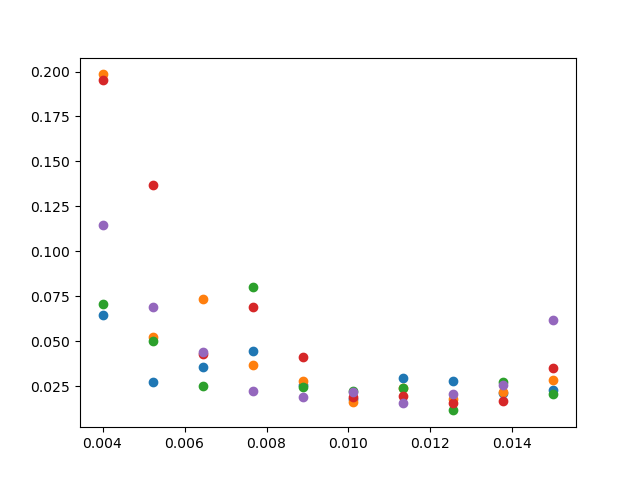

In [24]:
starting_params = {'disp_parameter': 0.010,
                'alpha': 1.0,
                'beta': 10.0}
sample_num = 1000
initial_energy = 23.0 * np.ones(sample_num)
sim_meta_params = META_PARAMS

plt.figure()

disp_parameters = jnp.linspace(0.004, 0.015, 10)
alphas = jnp.linspace(0.5, 1.5, 10)
betas = jnp.linspace(7, 13, 10)

for j in range(5):
    mmd_losses = []
    sim_params = copy.deepcopy(starting_params)

    for i, val in enumerate(disp_parameters):
        print(i, val)
        key, subkey = random.split(key)

        sim_params['disp_parameter'] = val
        #sim_params['alpha'] = val
        #sim_params['beta'] = val

        mmd_loss, grad_of_expected_value, updates = sample_and_get_updates(full_energy_paths, initial_energy, sim_meta_params, sim_params, subkey, sample_num=sample_num)

        mmd_losses.append(mmd_loss)

    print(disp_parameters, mmd_losses)
    plt.scatter(disp_parameters, mmd_losses)